In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels

# Loading the Data

In [2]:
raw_data = pd.read_csv('data/Index2018.csv')

In [3]:
df = raw_data.copy()

# Examining the Data

In [4]:
df.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


In [5]:
np.round(df.describe(), 2)

,spx,dax,ftse,nikkei
count,6269.00,6269.00,6269.00,6269.00
mean,1288.13,6080.06,5422.71,14597.06
std,487.59,2754.36,1145.57,4043.12
min,438.92,1911.70,2876.60,7054.98
25%,990.67,4069.35,4486.10,10709.29
50%,1233.42,5773.34,5662.43,15028.17
75%,1459.99,7443.07,6304.25,17860.47
max,2872.87,13559.60,7778.64,24124.15


In [6]:
# No missing values
df.isna().sum()

date      0
spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

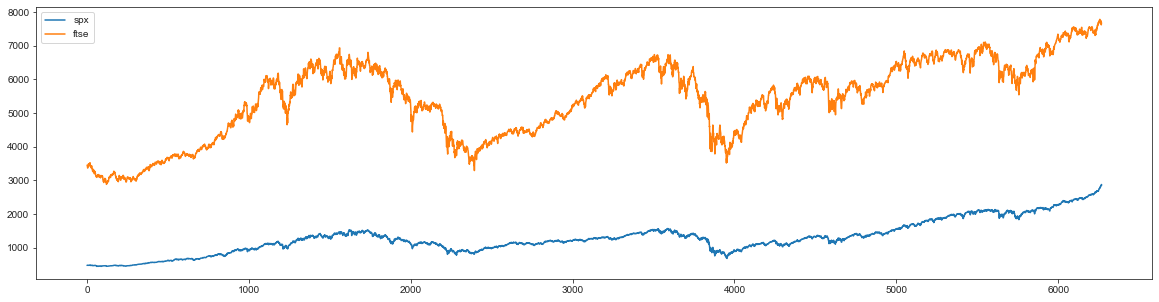

In [7]:
df.spx.plot(figsize=(20,5))
df.ftse.plot(figsize=(20,5))
plt.legend()

# QQ Plot for Examining Distribution

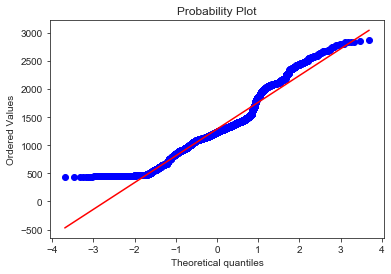

In [8]:
stats.probplot(df.spx, plot=plt)
plt.show()

The prices are **NOT** normally distributed!

# Fixing Date

In [9]:
df['date'] = pd.to_datetime(df.date, dayfirst=True)
df = df.set_index('date')

In [10]:
df.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


# Defining Constant Frequency

In [11]:
# Set to business days only
df = df.asfreq('b')

In [12]:
df.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [13]:
# Setting frequency generated 8 missing values
df.isna().sum()

spx       8
dax       8
ftse      8
nikkei    8
dtype: int64

In [14]:
# Front fill missing data (e.g. Jan 1st 2018)
df = df.fillna(method='ffill')

In [15]:
# Create new Column for a certain index (e.g. SPX) and remove rest
df['market_value'] = df.spx
df = df.drop(['spx', 'dax', 'ftse', 'nikkei'], axis=1)
df.head()

,market_value
date,
1994-01-07,469.90
1994-01-10,475.27
1994-01-11,474.13
1994-01-12,474.17
1994-01-13,472.47


# Train Test Splitting

In [16]:
train_size = int(len(df) * 0.8)

In [17]:
df_test = df.iloc[train_size:].copy()
df = df.iloc[:train_size].copy()

In [18]:
df.tail()

,market_value
date,
2013-04-01,1562.173837
2013-04-02,1570.252238
2013-04-03,1553.686978
2013-04-04,1559.979316
2013-04-05,1553.278930


In [19]:
df_test.head()

,market_value
date,
2013-04-08,1563.071269
2013-04-09,1568.607909
2013-04-10,1587.731827
2013-04-11,1593.369863
2013-04-12,1588.854623


# White Noise
= Data that has (1) a constant $\mu$, (2) a constant $\sigma$ and (3) is *NOT* autocorrelated.

In [20]:
wn = np.random.normal(loc=df.market_value.mean(), scale=df.market_value.std(), size=len(df))
df['wn'] = wn

In [21]:
df.describe()

,market_value,wn
count,5021.000000,5021.000000
mean,1091.651926,1083.887444
std,292.559287,288.167575
min,438.920000,27.708677
25%,914.620000,890.564112
50%,1144.650000,1085.331125
75%,1316.280729,1275.689364
max,1570.252238,2112.844664


Text(0.5, 1.0, 'White Noise Time Series')

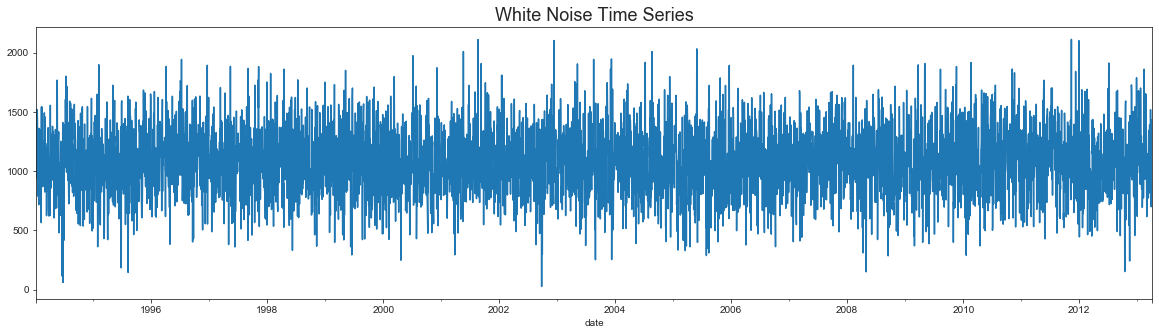

In [22]:
df.wn.plot(figsize=(20,5))
plt.title('White Noise Time Series', size=18)

# Random Walks

In [23]:
rw = pd.read_csv('data/RandWalk.csv')
rw.date = pd.to_datetime(rw.date, dayfirst=True)
rw.set_index('date', inplace=True)
rw = rw.asfreq('b')
df['rw'] = rw.price
rw.describe()

,price
count,5021.000000
mean,1269.944293
std,444.216793
min,585.483034
25%,931.550429
50%,1156.363045
75%,1488.362029
max,2715.508720


Text(0.5, 1.0, 'Random Walk vs SPX')

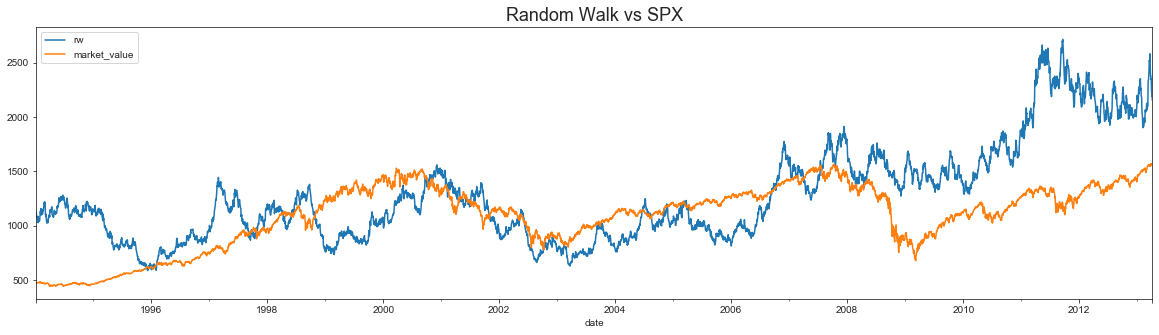

In [24]:
df[['rw', 'market_value']].plot(figsize=(20,5))
plt.title('Random Walk vs SPX', size=18)

# Stationarity
- Samples of same size (regardless of the starting point) should have *the same covariance*   

So they need to have...
- a constant mean
- a constant variance
- the same covariance for equally long samples: $Cov(x_n, x_{n+k}) = Cov(x_m, x_{m+k})$

## Testing for Stationarity: The Dickey-Fuller Test
### DF-Test
$H_0$: Non-Stationarity  
$H_1$: Stationarity

In [28]:
# SPX Closes
sm.tsa.adfuller(df.market_value) #p-value: 0.4121645696770626
# => FAIL TO REJECT NULL!

(-1.7369847452352427,
 0.4121645696770626,
 18,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 39904.880607487445)

In [29]:
# White Noise
sm.tsa.adfuller(df.wn) #p-value: 0.0
# => REJECT NULL!

(-71.16556892798043,
 0.0,
 0,
 5020,
 {'1%': -3.431653316130827,
  '5%': -2.8621159253018247,
  '10%': -2.5670765656497516},
 70665.63042583276)

In [30]:
# Random Walk
sm.tsa.adfuller(df.rw) #p-value: 0.6159849181617383
# => FAIL TO REJECT NULL!

(-1.3286073927689723,
 0.6159849181617383,
 24,
 4996,
 {'1%': -3.4316595802782865,
  '5%': -2.8621186927706463,
  '10%': -2.567078038881065},
 46299.333497595144)

# Decomposition
... into the components **Trend, Seasonality, Residuals**
## Naive Decomposition
Assumes linear relationship between the components.  
**Additive:** observed = trend + seasonal + residual   
**Multiplicative:** observed = trend * seasonal * residual

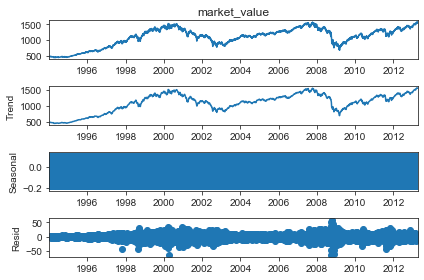

In [32]:
s_dec_add = sm.tsa.seasonal_decompose(df.market_value, model='additive')
s_dec_add.plot()
plt.show()

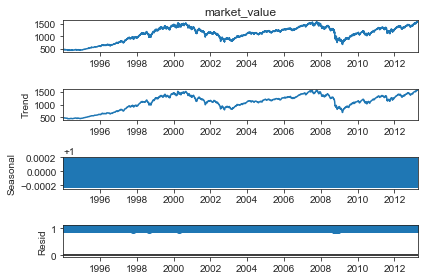

In [33]:
s_dec_mul = sm.tsa.seasonal_decompose(df.market_value, model='multiplicative')
s_dec_mul.plot()
plt.show()

# Autocorrelation

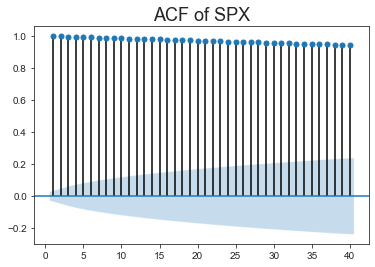

In [36]:
# SPX
statsmodels.graphics.tsaplots.plot_acf(df.market_value, lags=40, zero=False)
plt.title("ACF of SPX", size=18)
plt.show()
# Blue area is area of NO significance

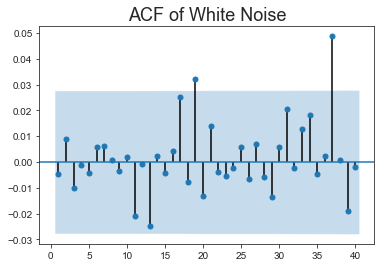

In [37]:
# White Noise
statsmodels.graphics.tsaplots.plot_acf(df.wn, lags=40, zero=False)
plt.title("ACF of White Noise", size=18)
plt.show()

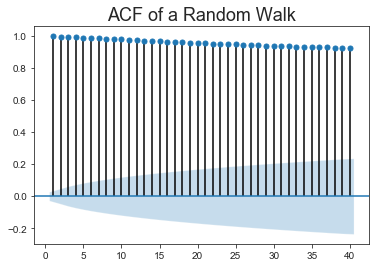

In [38]:
# Random Walk
statsmodels.graphics.tsaplots.plot_acf(df.rw, lags=40, zero=False)
plt.title("ACF of a Random Walk", size=18)
plt.show()

In [42]:
# Autocorrelation with a shift of 40 days
df.corrwith(df.shift(40))

market_value    0.977308
wn              0.006010
rw              0.954142
dtype: float64

# Partial Autocorrelation Function (PACF)
- The ACF function takes into account all *indirect* relationships between each day of the lagged data and the current day (e.g. prices 3 days ago influence the price 2 days ago which influences the price 1 day ago which influences the current price)
- PACF only takes into account the direct effect of the price $n$ days ago.

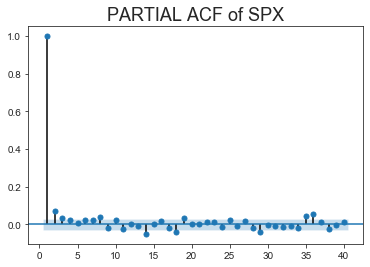

In [45]:
# SPX
statsmodels.graphics.tsaplots.plot_pacf(df.market_value, lags=40, zero=False, method='ols')
plt.title("PARTIAL ACF of SPX", size=18)
plt.show()

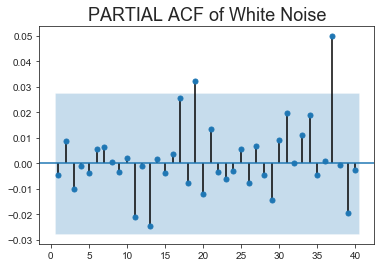

In [46]:
# White Noise
statsmodels.graphics.tsaplots.plot_pacf(df.wn, lags=40, zero=False, method='ols')
plt.title("PARTIAL ACF of White Noise", size=18)
plt.show()

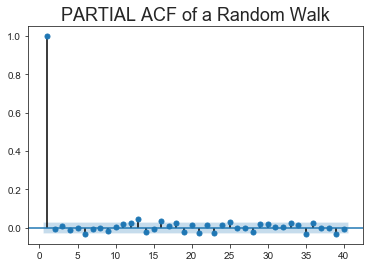

In [47]:
# Random Walk
statsmodels.graphics.tsaplots.plot_pacf(df.rw, lags=40, zero=False, method='ols')
plt.title("PARTIAL ACF of a Random Walk", size=18)
plt.show()

# Picking the Correct Model
- start with a simple model and extend it if new coeficients significantly differ from zero
- Simple model > Complicated model if the complicated model does not significantly improve predictions
    - Log-Likelihood-Ratio-Test (LLR): Only for models with different $df§
    - if $df$ for two models are the same: compare AIC and BIC
- Residuals should resemble **White Noise**